# Join Quality Measure for Datalakes
This notebook presents the code used to obtain our proposed join quality measure, specifically tailored to data lakes. This metric will combine a syntactic set overlap computation (multiset Jaccard) with the cardinality proportion (acting as a lightweight indicators for semantic relatedness).

In [1]:
import numpy as np
import pandas as pd
import math
import os
from scipy import stats
from scipy.stats import truncnorm

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns # to make some plots look better

from tqdm import tqdm

In [ ]:
data_folder = 'C:/Projects/freyja/data/'
datalake_folder = 'C:/Projects/benchmarks/freyja/datalake/' # Path where the Freyja benchmark is stored

# Calculate metrics
The following code can be to obtain the four metrics showcased in the paper: Containment ($C$), Jaccard ($J$), Multiset Jaccard ($MJ$) and the Cardinality Proportion ($K$).

Given a dataset with the pairs of columns (`joins`, with attributes `ds_name`, `att_name`, `ds_name_2`, `att_name_2`) and a path to get the files (`datalake_folder`) it creates a new dataset with the specified metrics for each pair.

In [ ]:
# Get all potential pairs of joins in the data lake

from itertools import product

csv_files = [f for f in os.listdir(datalake_folder) if f.endswith('.csv')] # Get a list of all CSV files in the folder
dfs_columns = {} # Dictionary to store DataFrames with their columns

# Load each CSV file and get column names
for file in csv_files:
    file_path = os.path.join(datalake_folder, file)
    df = pd.read_csv(file_path)
    dfs_columns[file] = df.columns.tolist()

column_pairs = []

# Create pairs using the product of columns from different files
for file1, columns1 in dfs_columns.items():
    for file2, columns2 in dfs_columns.items():
        if file1 != file2:  # Ensure we are looking at different files
            pairs = product(columns1, columns2)
            column_pairs.extend([(file1, col1, file2, col2) for col1, col2 in pairs])

pairs_df = pd.DataFrame(column_pairs, columns=['ds_name', 'att_name', 'ds_name_2', 'att_name_2'])

pairs_df.to_csv(f'{data_folder}/raw_joins.csv', index=False)

In [ ]:
def calculateMetrics(row):
  ds1 = pd.read_csv(datalake_folder + row["ds_name"], header = 0)
  col1 = ds1[row["att_name"]].astype(str).str.lower().str.strip()
  ds2 = pd.read_csv(datalake_folder + row["ds_name_2"], header = 0)
  col2 = ds2[row["att_name_2"]].astype(str).str.lower().str.strip()

  set1 = set(col1)
  set2 = set(col2)

  intersection = len(set1.intersection(set2))
  union = len(set1.union(set2))
  lengthes = len(col1) + len(col2) # Careful! The lengthes are of the columns, not the set. That is, we include repeated values

  jaccard = intersection / union
  containment = intersection / min(len(set1), len(set2))
  multisetJaccard = intersection / lengthes
  k = min(len(set1),len(set2))/max(len(set1),len(set2))

  return pd.Series([containment, jaccard, multisetJaccard, k])

In [ ]:
# Compute the metrics for all the joins

raw_joins = pd.read_csv(f'{data_folder}/raw_joins.csv', sep=',')

tqdm.pandas() # Enable tqdm for pandas apply
metrics = raw_joins.progress_apply(calculateMetrics, axis=1)
metrics.columns = ["containment", "jaccard", "multiset_jaccard", "k"]

joins_with_metrics = pd.concat([raw_joins, metrics], axis=1)

# Data loading

First, we load the ground truth we will use to generate the metric. 

That is, a dataframe with joins (pairs of attributes from different datasets) and the following measurements: containment ($C$), cardinality proportion ($K$), Jaccard ($J$) and multiset Jaccard ($MJ$) scores. $MJ$ and $K$ will be used to derive the final metric, whereas $C$ and $J$ will be used to as baselines to test the effectiveness of $MJ$.

Additionally, each join is assigned a type of relationship (semantic or syntactic). A join is syntactic if containment > 0.1. A join is semantic if, on top of being syntactic, the columns have a meaningful relationships (e.g. both columns represent countries). This assignment has been done manually.

In [ ]:
sem_syn_joins = pd.read_csv(f'{data_folder}/semantic_and_syntactic_joins.csv', header = 0)
sem_syn_joins

,ds_name,att_name,ds_name_2,att_name_2,containment,cardinality_proportion,jaccard,multiset_jaccard,relationship
0,Distributions_data_2016.csv,demographics,Tech_sector_diversity_demographics_2016.csv,raceEthnicity,0.230769,0.461538,0.187500,0.000186,syntactic
1,USA_cars_datasets.csv,country,world_country.csv,Name,0.500000,0.008368,0.004167,0.000365,semantic
2,books_updated.csv,languageCode,countries_metadatacountries.csv,CountryCode,0.360000,0.101215,0.034091,0.000878,syntactic
3,cars.csv,color,colors.csv,name,0.750000,0.088889,0.065217,0.000233,semantic
4,cars.csv,transmission,imdb_ijs_movies.csv,name,0.500000,0.000044,0.000022,0.000011,syntactic
...,...,...,...,...,...,...,...,...,...
4313,student-mat.csv,Pstatus,dataset_1_anneal.csv,temper_rolling,0.500000,0.500000,0.333333,0.000773,syntactic
4314,top10s.csv,title,song_data.csv,songname,0.493151,0.045159,0.021567,0.014713,semantic
4315,top_100_books.csv,author2,books_updated.csv,authors,0.409639,0.017903,0.006999,0.003268,semantic
4316,us_companies.csv,companytype,worldcitiespop.csv,Country,0.111111,0.038462,0.000000,0.000000,syntactic


In [16]:
count_syntactic = (sem_syn_joins['relationship'] == 'syntactic').sum()
count_semantic = (sem_syn_joins['relationship'] == 'semantic').sum()

print(f"Number of syntactic joins: {count_syntactic}")
print(f"Number of semantic joins: {count_semantic}")

sem_syn_joins.describe()

Number of syntactic joins: 2622
Number of semantic joins: 1696


,containment,cardinality_proportion,jaccard,multiset_jaccard
count,4318.000000,4.318000e+03,4318.000000,4318.000000
mean,0.523632,3.607196e-01,0.216043,0.052426
std,0.301818,3.715399e-01,0.283126,0.104592
min,0.100592,4.251912e-07,0.000000,0.000000
25%,0.250000,8.547009e-03,0.004049,0.000170
50%,0.500000,2.040816e-01,0.090909,0.002138
75%,0.794326,6.794118e-01,0.339653,0.047600
max,1.000000,1.000000e+00,1.000000,0.500000


# Initial experiments: which set-overlap metric to use?

Firstly, we want to assess whether multiset Jaccard (the metric that we want to explore the performance of) is better than traditional set overlap metrics (containment and Jaccard) in separating semantic from syntatic joins.

## Proportion of semantic-syntactic joins

We start by ordering the joins in three different "rankings", one per each set overlap metric, with higher values of the metrics being placed at the top. Then, we separate each ranking into its four quartiles, and measure the proportion of semantic and syntactic joins in each. Ideally, we should see that for quartiles 3 and 4 (i.e. those representing the the top 50% of joins according to the metrics), they have a higher proportion of semantic joins than buckets 1 and 2.

Note that the ground truth contains more syntactic than semantic joins.

**Result**: Containment is clearly worse than both Jaccard metrics in developing this separation. Multiset Jaccard seems to make the distribution slightly better than Jaccard, although the evidence is small.

In [17]:
def proportions(metric, num_partitions):
  sem_syn_joins[metric + '_rank'] = sem_syn_joins[metric].rank(method="first", ascending=False) # Create a ranking for the metric
  sem_syn_joins['partition_' + metric] = pd.qcut(sem_syn_joins[metric], q=num_partitions, labels=False) + 1 # Partition the ranking in as many segments as desired

  counts = {str(i): {'sem': 0, 'syn': 0} for i in range(1, num_partitions + 1)} # Initialize counts dictionary based on the number of partitions

  # Count occurrences for both typologies
  for _, row in sem_syn_joins.iterrows():
      if row["relationship"] == "semantic":
          counts[str(row['partition_' + metric])]['sem'] += 1
      else:
          counts[str(row['partition_' + metric])]['syn'] += 1

  sem_counts = [counts[key]["sem"] for key in counts]
  syn_counts = [counts[key]["syn"] for key in counts]
  return sem_counts, syn_counts

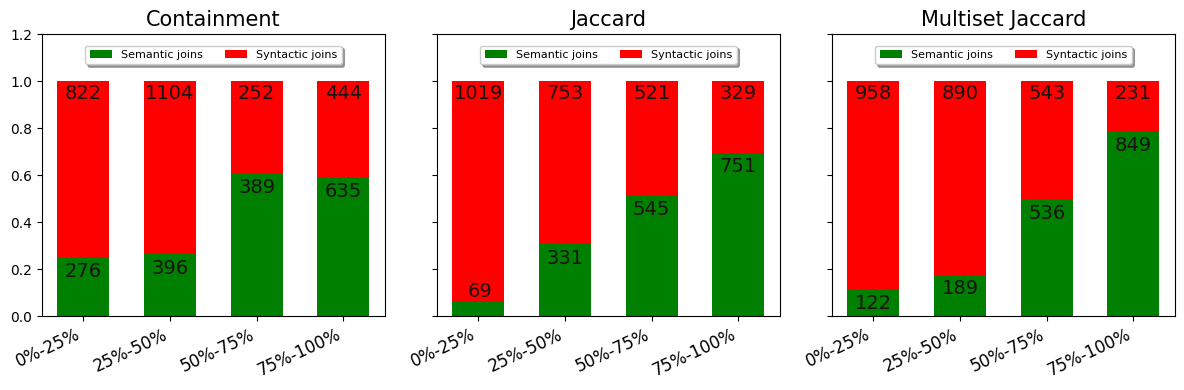

In [18]:
proportions_c = proportions("containment", 4)
proportions_j = proportions("jaccard", 4)
proportions_mj = proportions("multiset_jaccard", 4)

values_sets = [
    (proportions_c[0], proportions_c[1], "Containment"),
    (proportions_j[0], proportions_j[1], "Jaccard"),
    (proportions_mj[0], proportions_mj[1], "Multiset Jaccard")
]

fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

categories = ['0%-25%', '25%-50%', '50%-75%', '75%-100%']
bar_width = 0.6
index = np.arange(len(categories))

for i, (values1, values2, title) in enumerate(values_sets):
    total_values = np.array(values1) + np.array(values2)
    normalized_values1 = np.array(values1) / total_values
    normalized_values2 = np.array(values2) / total_values

    ax = axs[i]

    bars1 = ax.bar(index, normalized_values1, bar_width, label='Semantic joins', color='green')
    bars2 = ax.bar(index, normalized_values2, bar_width, label='Syntactic joins', color='red', bottom=normalized_values1)

    ax.set_title(title, fontsize=15)
    ax.set_xticks(index)
    ax.set_xticklabels(categories, rotation=25, ha='right', fontsize=12)
    ax.set_ylim(0, 1.2)

    for bar1, bar2, val1, val2 in zip(bars1, bars2, values1, values2):
        if val1 == 69:  # Special case
            ax.text(bar1.get_x() + bar1.get_width() / 1.9, bar1.get_height(), val1, ha='center', va='bottom', color="#1B1212", size=14)
        else:
            ax.text(bar1.get_x() + bar1.get_width() / 2., bar1.get_height() - 0.1, val1, ha='center', va='bottom', color="#1B1212", size=14)
        ax.text(bar2.get_x() + bar2.get_width() / 2., bar2.get_height() + bar1.get_height() - 0.01, val2, ha='center', va='top', color="#1B1212", size=14)

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.98), fancybox=True, shadow=True, ncol=2, fontsize=8)

plt.tight_layout()
plt.show()

## Precision at $k$

The previous experiment takes into consideration all the joins in the ground truth to assess the capacity of the metrics to separate semantic and syntactic joins. On a real scenario, the end user will only consider the top $k$ joins (i.e. those with higher values of join quality). Hence, we will now focus only on the top joins.

To do so we will employ the precision at $k$ (P@$k$) metric, which is similar to the previous procedure: how many of the top $k$ joins are semantic joins? We will set $k$ to 100, which is already far more than what a realistic end user would consider.

**Result**: We can observe that multiset Jaccard is clearly better at placing semantic joins in the top spots. In fact, both containment and Jaccard place syntactic joins in the first few positions, which means that the first joins to be given to the user would be false positives. We have a clear argument to prefer multiset Jaccard to the other two.

In [19]:
def get_precisions(metric, k_max):
    results = []
    sem_syn_joins[metric + '_rank'] = sem_syn_joins[metric].rank(method="first", ascending=False) # Create a ranking for the metric
    for k in range(1, k_max + 1, 2):
        groundTruthSorted_k = sem_syn_joins.sort_values(by=metric + '_rank').head(k)
        recall_k = (groundTruthSorted_k['relationship'] == "semantic").sum() / k
        results.append(recall_k)
    return results

def precision_at_k_set_overlap_metrics(k_max):
    c = get_precisions("containment", k_max)
    j = get_precisions("jaccard", k_max)
    mj = get_precisions("multiset_jaccard", k_max)

    x = list(range(1, k_max + 1, 2)) # x values for the plot

    plt.figure(figsize=(8, 4))

    plt.plot(x, c, label='Containment')
    plt.plot(x, j, label='Jaccard')
    plt.plot(x, mj, label='Multiset Jaccard')

    plt.xlabel('k', fontsize=14)
    plt.ylabel('Proportion of semantic joins', fontsize=14)
    plt.xlim(-0.4, k_max + 1)
    plt.ylim(0, 1.03)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), fancybox=True, shadow=True, ncol=3, fontsize=12)
    plt.grid(True)

    plt.show()

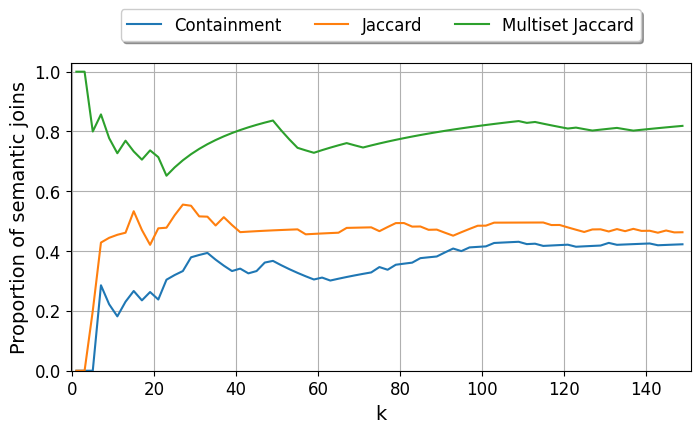

In [20]:
precision_at_k_set_overlap_metrics(150)

# Relevance of $K$

We can justify the employment of the cardinality proportion in a preliminary manner by evaluating its capacity to segregate semantic from syntactic joins.

**Result**: The plots showcase a clear positive correlation between the value of the cardinality proportion and the amount of semantic joins. That is, higher values of $K$ tend to correspond with semantic joins.

In [21]:
def proportions_joined(metric, num_quantiles, sample_size=1500):
    # Sample data for semantic and syntactic relationships
    sem_sample = sem_syn_joins[sem_syn_joins["relationship"] == "semantic"].sample(n=sample_size, random_state=0)
    syn_sample = sem_syn_joins[sem_syn_joins["relationship"] == "syntactic"].sample(n=sample_size, random_state=0)
    combined_sample = pd.concat([sem_sample, syn_sample])

    # Rank the metric values and divide into quantiles
    combined_sample[metric + '_rank'] = combined_sample[metric].rank(method="first", ascending=False)
    combined_sample['quartile_' + metric] = pd.qcut(combined_sample[metric], q=num_quantiles, labels=False) + 1

    # Initialize counts dictionary
    quartile_counts = {i: {'sem': 0, 'syn': 0} for i in range(1, num_quantiles + 1)}

    # Count occurrences in each quartile
    for quartile, relationship in zip(combined_sample['quartile_' + metric], combined_sample['relationship']):
        if relationship == "semantic":
            quartile_counts[quartile]['sem'] += 1
        else:
            quartile_counts[quartile]['syn'] += 1

    # Extract counts for semantic and syntactic relationships
    sem_counts = [quartile_counts[q]['sem'] for q in sorted(quartile_counts.keys())]
    syn_counts = [quartile_counts[q]['syn'] for q in sorted(quartile_counts.keys())]

    return sem_counts, syn_counts

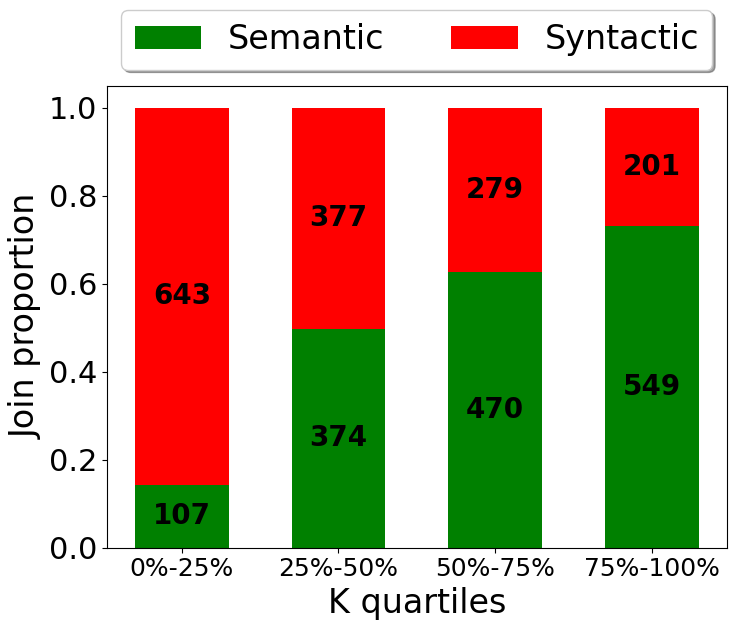

In [22]:
values_sets = proportions_joined("cardinality_proportion", 4) # [0] -> semantic counts, [1] -> syntactic counts

categories = ['0%-25%', '25%-50%', '50%-75%', '75%-100%']

# Normalizing the values
total_values = np.array(values_sets[0]) + np.array(values_sets[1])
semantic_values_normalized = np.array(values_sets[0]) / total_values
syntactic_values_normalized = np.array(values_sets[1]) / total_values

x_positions = np.arange(len(categories))
bar_width = 0.6

fig, ax = plt.subplots(figsize=(8, 6))

bars1 = ax.bar(x_positions, semantic_values_normalized, bar_width, color='green', label='Semantic') # Plot bottom bars (semantic)
bars2 = ax.bar(x_positions, syntactic_values_normalized, bar_width, bottom=semantic_values_normalized, color='red', label='Syntactic') # Plot top bars (syntactic) stacked on top

# Annotate the bottom bars
for x, y, val in zip(x_positions, semantic_values_normalized, values_sets[0]):
    ax.text(x, y / 2, str(val), ha='center', va='center', color='black', fontsize=20, weight='bold')

# Annotate the top bars
for x, y1, y2, val in zip(x_positions, semantic_values_normalized, syntactic_values_normalized, values_sets[1]):
    ax.text(x, y1 + y2 / 2, str(val), ha='center', va='center', color='black', fontsize=20, weight='bold')

ax.set_xticks(x_positions)
ax.set_xticklabels(categories, fontsize=18)
ax.set_ylabel('Join proportion', fontsize=24)
ax.set_xlabel('K quartiles', fontsize=24)
ax.tick_params(axis='y', labelsize=22)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, fontsize=24, fancybox=True, shadow=True)

plt.show()

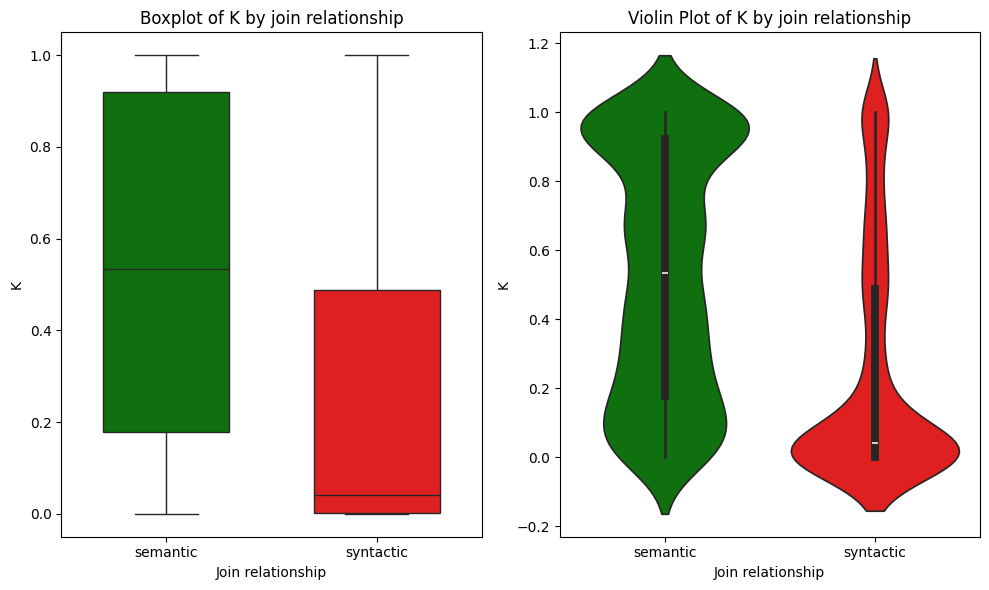

In [23]:
sample_size=1500

sem_sample = sem_syn_joins[sem_syn_joins["relationship"] == "semantic"].sample(n=sample_size, random_state=0)
syn_sample = sem_syn_joins[sem_syn_joins["relationship"] == "syntactic"].sample(n=sample_size, random_state=0)
combined_sample = pd.concat([sem_sample, syn_sample])

plt.figure(figsize=(10, 6))

# Create the first subplot for the boxplot
plt.subplot(1, 2, 1) 
sns.boxplot(x='relationship', hue='relationship', y='cardinality_proportion', data=combined_sample, palette={"syntactic": 'red', "semantic": 'green'}, width=0.6)
plt.title('Boxplot of K by join relationship')
plt.xlabel('Join relationship')
plt.ylabel('K')

# Create the second subplot for the violin plot
plt.subplot(1, 2, 2) 
sns.violinplot(x='relationship', hue='relationship', y='cardinality_proportion', data=combined_sample, palette={"syntactic": 'red', "semantic": 'green'})
plt.title('Violin Plot of K by join relationship')
plt.xlabel('Join relationship')
plt.ylabel('K')

plt.tight_layout() 
plt.show()

# Multi-class metric

By plotting the scores for $MJ$ and $K$ obtained by the ground truth, we can observe a positive correlation between the values of the metrics and the semantic category of the joins. That is, the higher the values of $MJ$ and $K$, the more likely for a join to be semantic.

Hence, we define a multiclass function that maps the instance of the ground truth onto four (by default, but there might be many levels), quality categories. The idea is that the "higher" buckets should contain a higher proportion of semantic joins compared to syntactic joins. It is important to realize that this is not meant to define 100% accurate thresholds (as it is impossible), but rather to capture general trends. Also, the selected function is arbitrary, as there is, literally, an infinite amount of functions to try. Hence, our proposal is a reasonable chose among many. 

We also plot the result of applying such function over our ground truth.

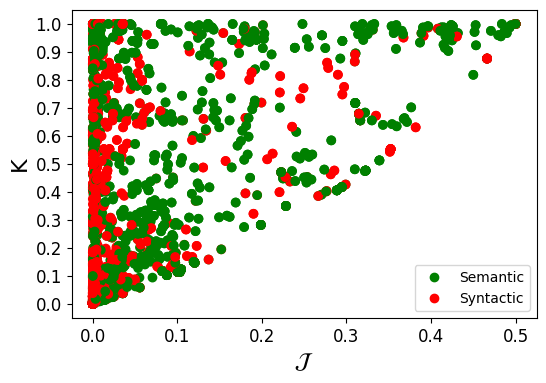

In [24]:
def pltcolor(lst):
    cols = []
    for l in lst:
        if l == 'semantic':
            cols.append(0)
        elif l == 'syntactic':
            cols.append(1)
        else:
            cols.append(2)
    return cols

cols = pltcolor(sem_syn_joins['relationship'])

classes = ['Semantic', 'Syntactic']
colours = mcolors.ListedColormap(['g', 'b', 'r'])

plt.figure(figsize=(6, 4))

scatter = plt.scatter(sem_syn_joins["multiset_jaccard"], sem_syn_joins["cardinality_proportion"], c=cols, cmap=colours)
plt.xticks(np.linspace(0, 0.5, 6), fontsize=12)
plt.yticks(np.linspace(0, 1, 11), fontsize=12)
plt.xlabel(r'$\mathcal{J}$', fontsize=16)
plt.ylabel('K', fontsize=16)

plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.show()

In [25]:
def discreteQuality(MJ, K, L):
  for i in range(0,L): # range() does not include the last element
    if MJ >= 1/2**(i+1) and K >= 1-(i/(L)): # i + 1 as Mj is bounded in [0, 0.5] (i + 1 is equivalent to 2 * MJ)
      return (L-i+1)/L
  return 0

C:\Users\marcm\AppData\Local\Temp\ipykernel_11324\1350027102.py:10: UserWarning: Mismatched number of handles and labels: len(handles) = 5 len(labels) = 4
  plt.legend(handles=scatter.legend_elements()[0], labels=classes)


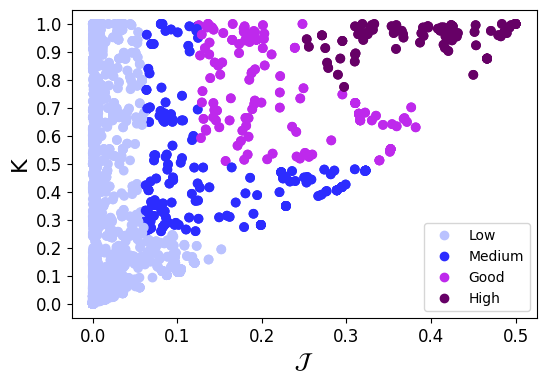

In [26]:
sem_syn_joins['discrete_quality'] = sem_syn_joins.apply(lambda row: discreteQuality(row['multiset_jaccard'], row['cardinality_proportion'], 4), axis=1)

classes = ['Low', 'Medium', 'Good', 'High']
colours = mcolors.ListedColormap(['#bac2ff', '#2c2cff', '#be29ec', '#660066'])

plt.figure(figsize=(6, 4))
plt.xticks(np.linspace(0, 1, 11), fontsize=12)
plt.yticks(np.linspace(0, 1, 11), fontsize=12)
scatter = plt.scatter(sem_syn_joins['multiset_jaccard'], sem_syn_joins['cardinality_proportion'], c=sem_syn_joins['discrete_quality'], cmap=colours)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)

plt.xlabel(r'$\mathcal{J}$', fontsize=16)
plt.ylabel('K', fontsize=16)

plt.show()

# Continuous metric
Finally, we transform the multi-class metric to a continuous one, as it would allow us to create rankings. To do so, we fit a multiple Gaussian distribution over the multi-class metric.

That is, we will compute the Wasserstein distance between the discrete function and continuous function generated from Gaussian distributions with a series of fixed parameters. The final continuous function is the one that minimized the Wasserstein distance both for $K$ and $MJ$.

We also showcase that $L = 4$ is the value that minimizes the distances, hence it will be the value selected for the final function.

In [27]:
def defineModel(mu_MJ, mu_K, sigma_mj, sigma_k):
  mu_v = [mu_MJ , mu_K] # Mean vector
  """
  The covariance matrix is defined as:
  cov = [[sigma_v[0]**2, 0],
        [0, sigma_v[1]**2]]
  """
  sigma_v = [sigma_mj, sigma_k] # Variance vector (we assume an equal sigma for MJ and K)
  a1, b1 = (- mu_v[0]) / sigma_v[0], (1 - mu_v[0]) / sigma_v[0] # Defining MJ limits
  a2, b2 = (- mu_v[1]) / sigma_v[1], (1 - mu_v[1]) / sigma_v[1] # Defining K limits
  MJmodel = truncnorm(a1, b1, scale=sigma_v[0], loc=mu_v[0]) # Creating MJ model
  Kmodel = truncnorm(a2, b2, scale=sigma_v[1], loc=mu_v[1]) # Creating K model
  return MJmodel,Kmodel

def continuousJoinQualityWithAll(MJ,K,MJmodel,Kmodel):
  return MJmodel.cdf(MJ)*Kmodel.cdf(K)

Best mu for MJ is 0.1111111111111111
Best sigma for MJ is 0.1
Best wasserstein_distance for MJ is 0.06743474780215303


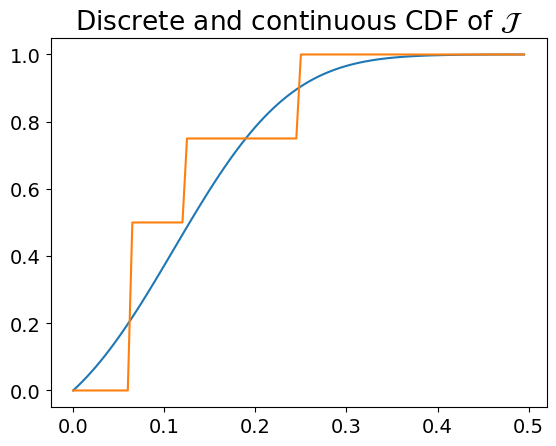

Best mu for K is 0.4444444444444444
Best sigma for K is 0.19
Best wasserstein_distance for K is 0.082694768143684


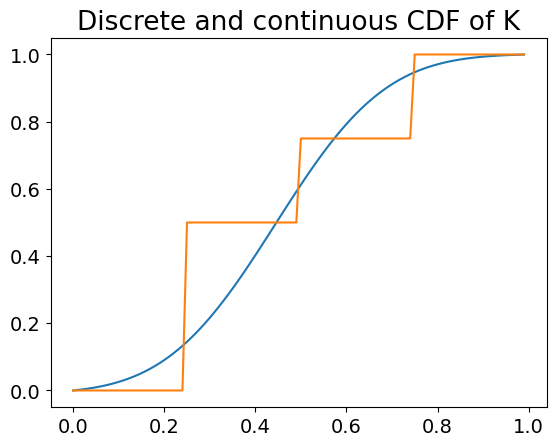

In [83]:
def evaluate_model(mu_values, sigma_values, L, is_MJ_model=True):
    best_mu = 1
    best_sigma = 1
    best_distance = math.inf

    for mu in mu_values:
        for sigma in sigma_values:
            cdf_model = []
            discrete_model = []

            if is_MJ_model:
                MJmodel, Kmodel = defineModel(mu, 0, sigma, 0.5)
                X = np.arange(0, 0.5, 0.005)
            else:
                MJmodel, Kmodel = defineModel(0, mu, 0.5, sigma)
                X = np.arange(0, 1, 0.01)

            for x in X:
                if is_MJ_model:
                    cdfVal = continuousJoinQualityWithAll(x, 1, MJmodel, Kmodel)
                    discreteVal = discreteQuality(x, 1, L)
                else:
                    cdfVal = continuousJoinQualityWithAll(1, x, MJmodel, Kmodel)
                    discreteVal = discreteQuality(1, x, L)

                cdf_model.append(cdfVal)
                discrete_model.append(discreteVal)

            d = stats.wasserstein_distance(cdf_model, discrete_model)
            if d < best_distance:
                best_distance = d
                best_mu = mu
                best_sigma = sigma

    return best_mu, best_sigma, best_distance

def plot_models(mu, sigma, L, is_MJ_model=True):
    if is_MJ_model:
        MJmodel, Kmodel = defineModel(mu, 0, sigma, 0.5)
        X = np.arange(0, 0.5, 0.005)
    else:
        MJmodel, Kmodel = defineModel(0, mu, 0.5, sigma)
        X = np.arange(0, 1, 0.01)

    models = []
    cdf_model = []
    discrete_model = []

    for x in X:
        if is_MJ_model:
            cdfVal = continuousJoinQualityWithAll(x, 1, MJmodel, Kmodel)
            discreteVal = discreteQuality(x, 1, L)
        else:
            cdfVal = continuousJoinQualityWithAll(1, x, MJmodel, Kmodel)
            discreteVal = discreteQuality(1, x, L)

        cdf_model.append(cdfVal)
        discrete_model.append(discreteVal)
        models.append([cdfVal, discreteVal])

    plt.plot(X, models)
    title = "Discrete and continuous CDF of $\mathcal{J}$" if is_MJ_model else "Discrete and continuous CDF of K"
    plt.title(title, fontsize=19)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

L = 4
mu_values = np.linspace(0, 1, 10, endpoint=True)
sigma_values = np.linspace(0.1, 1, 10, endpoint=False)

best_mu_MJ, best_sigma_MJ, best_distance_MJ = evaluate_model(mu_values, sigma_values, L, is_MJ_model=True)
print("Best mu for MJ is", best_mu_MJ)
print("Best sigma for MJ is", best_sigma_MJ)
print("Best wasserstein_distance for MJ is", best_distance_MJ)
plot_models(best_mu_MJ, best_sigma_MJ, L, is_MJ_model=True)

best_mu_K, best_sigma_K, best_distance_K = evaluate_model(mu_values, sigma_values, L, is_MJ_model=False)
print("Best mu for K is", best_mu_K)
print("Best sigma for K is", best_sigma_K)
print("Best wasserstein_distance for K is", best_distance_K)
plot_models(best_mu_K, best_sigma_K, L, is_MJ_model=False)

**Important:** We have empirically (and a bit by accident) seen that the following values provide better results in the evaluation: mu for $MJ$ = 0.44, mu for $K$ = 0, sigma for $MJ$ = 0.19, sigma for $K$ = 0.28. This suggests that the discrete function we have chose is not the best and can be improved. According to the values, $MJ$ should be more aggressive (mean very close to 0.5, the maximum value), whereas $K$ should be more relaxed (mean = 0).

In [84]:
for L in range(1, 17):
  mu_values_mj = np.linspace(0, 0.5, 10, endpoint=True)
  mu_values_k = np.linspace(0, 1, 10, endpoint=True)
  sigma_values_mj = np.linspace(0.1, 0.5, 10, endpoint=False)
  sigma_values_k = np.linspace(0.1, 1, 10, endpoint=False)

  best_mu_MJ, best_sigma_MJ, best_distance_MJ = evaluate_model(mu_values_mj, sigma_values_mj, L, is_MJ_model=True)
  print(f"L = {L}, mu MJ = {best_mu_MJ}, sigma MJ = {best_sigma_MJ}, wasserstein_distance MJ {best_distance_MJ}")
  # plot_models(best_mu_MJ, best_sigma_MJ, L, is_MJ_model=True)

  best_mu_K, best_sigma_K, best_distance_K = evaluate_model(mu_values_k, sigma_values_k, L, is_MJ_model=False)
  print(f"L = {L}, mu K = {best_mu_K}, sigma K = {best_sigma_K}, wasserstein_distance K {best_distance_K}")
  # plot_models(best_mu_K, best_sigma_K, L, is_MJ_model=False)

  print("-------------------")

L = 1, mu MJ = 0.5, sigma MJ = 0.1, wasserstein_distance MJ 0.07730482771460602
L = 1, mu K = 1.0, sigma K = 0.1, wasserstein_distance K 0.0748549575500089
-------------------
L = 2, mu MJ = 0.2222222222222222, sigma MJ = 0.1, wasserstein_distance MJ 0.15912385682766383
L = 2, mu K = 0.4444444444444444, sigma K = 0.1, wasserstein_distance K 0.08974198563965027
-------------------
L = 3, mu MJ = 0.1111111111111111, sigma MJ = 0.1, wasserstein_distance MJ 0.09125659983770273
L = 3, mu K = 0.4444444444444444, sigma K = 0.1, wasserstein_distance K 0.08858400521982207
-------------------
L = 4, mu MJ = 0.0, sigma MJ = 0.14, wasserstein_distance MJ 0.060693038252928135
L = 4, mu K = 0.4444444444444444, sigma K = 0.19, wasserstein_distance K 0.082694768143684
-------------------
L = 5, mu MJ = 0.0, sigma MJ = 0.1, wasserstein_distance MJ 0.052583546838557385
L = 5, mu K = 0.3333333333333333, sigma K = 0.37, wasserstein_distance K 0.0661817403073662
-------------------
L = 6, mu MJ = 0.0, sigm

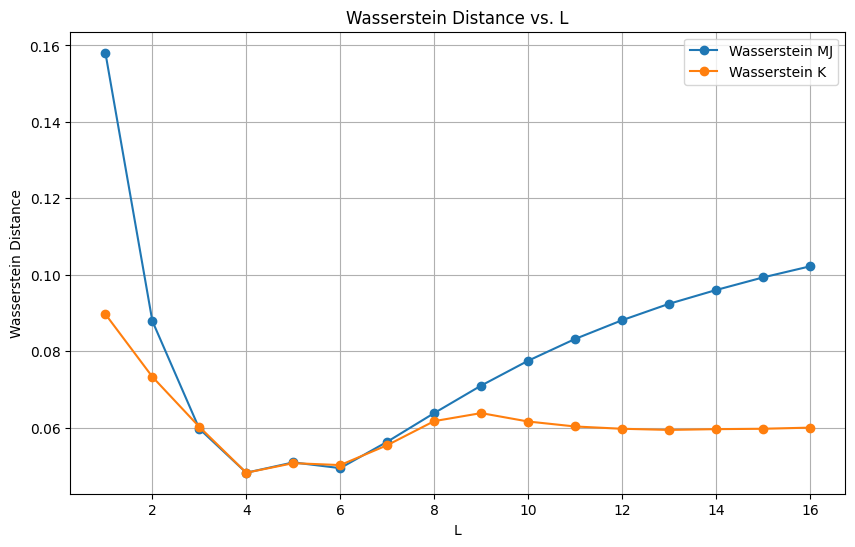

In [ ]:
# Lists to store results
distances_MJ = []
distances_K = []
Ls = range(1, 17)

for L in tqdm(Ls):
    mu_values_mj = np.linspace(0, 0.5, 10, endpoint=True)
    mu_values_k = np.linspace(0, 1, 10, endpoint=True)
    sigma_values_mj = np.linspace(0.1, 0.5, 10, endpoint=False)
    sigma_values_k = np.linspace(0.1, 1, 10, endpoint=False)

    best_mu_MJ, best_sigma_MJ, best_distance_MJ = evaluate_model(mu_values_mj, sigma_values_mj, L, is_MJ_model=True)
    best_mu_K, best_sigma_K, best_distance_K = evaluate_model(mu_values_k, sigma_values_k, L, is_MJ_model=False)

    # print(f"L = {L}, mu MJ = {best_mu_MJ}, sigma MJ = {best_sigma_MJ}, wasserstein_distance MJ {best_distance_MJ}")
    # print(f"L = {L}, mu K = {best_mu_K}, sigma K = {best_sigma_K}, wasserstein_distance K {best_distance_K}")
    # print("-------------------")
      
    distances_MJ.append(best_distance_MJ)
    distances_K.append(best_distance_K)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(Ls, distances_MJ, marker='o', label='MJ Model')
plt.plot(Ls, distances_K, marker='s', label='K Model')
plt.xlabel('L')
plt.ylabel('Best Wasserstein Distance')
plt.title('Best Wasserstein Distance vs L for MJ and K Models')
plt.legend()
plt.grid(True)
plt.show()

In [2]:
def continuousJoinQuality(MJ,K,strictness):
  mu_v = [0.44 + 0.25*strictness, 0 + 0.25*strictness]
  """
  The covariance matrix is defined as:
  cov = [[sigma_v[0]**2, 0],
        [0, sigma_v[1]**2]]
  """
  sigma_v = [0.19, 0.28]
  a1, b1 = (- mu_v[0]) / sigma_v[0], (1 - mu_v[0]) / sigma_v[0]
  a2, b2 = (- mu_v[1]) / sigma_v[1], (1 - mu_v[1]) / sigma_v[1]
  MJmodel = truncnorm(a1, b1, scale=sigma_v[0], loc=mu_v[0])
  Kmodel = truncnorm(a2, b2, scale=sigma_v[1], loc=mu_v[1])
  return MJmodel.cdf(MJ)*Kmodel.cdf(K)

# Strictness

Finally, we will provide the metric with some capacity to generalize by defining a strictness modifier. The higher the strictness, the more restrictive it will be when defining the scoring of the joins. That is, a higher strictness value implies that the higher scores of MJ and K are necessary to achieve a high join quality score. We define three levels: relaxed, balanced (which is the one we build the final model with) and strict.

In [43]:
sem_syn_joins['relaxed_continous_quality'] = sem_syn_joins.apply(lambda row: continuousJoinQuality(row['multiset_jaccard'],row['cardinality_proportion'], 0), axis=1)
sem_syn_joins['balanced_continous_quality'] = sem_syn_joins.apply(lambda row: continuousJoinQuality(row['multiset_jaccard'],row['cardinality_proportion'], 0.25), axis=1)
sem_syn_joins['strict_continous_quality'] = sem_syn_joins.apply(lambda row: continuousJoinQuality(row['multiset_jaccard'],row['cardinality_proportion'], 0.5), axis=1)

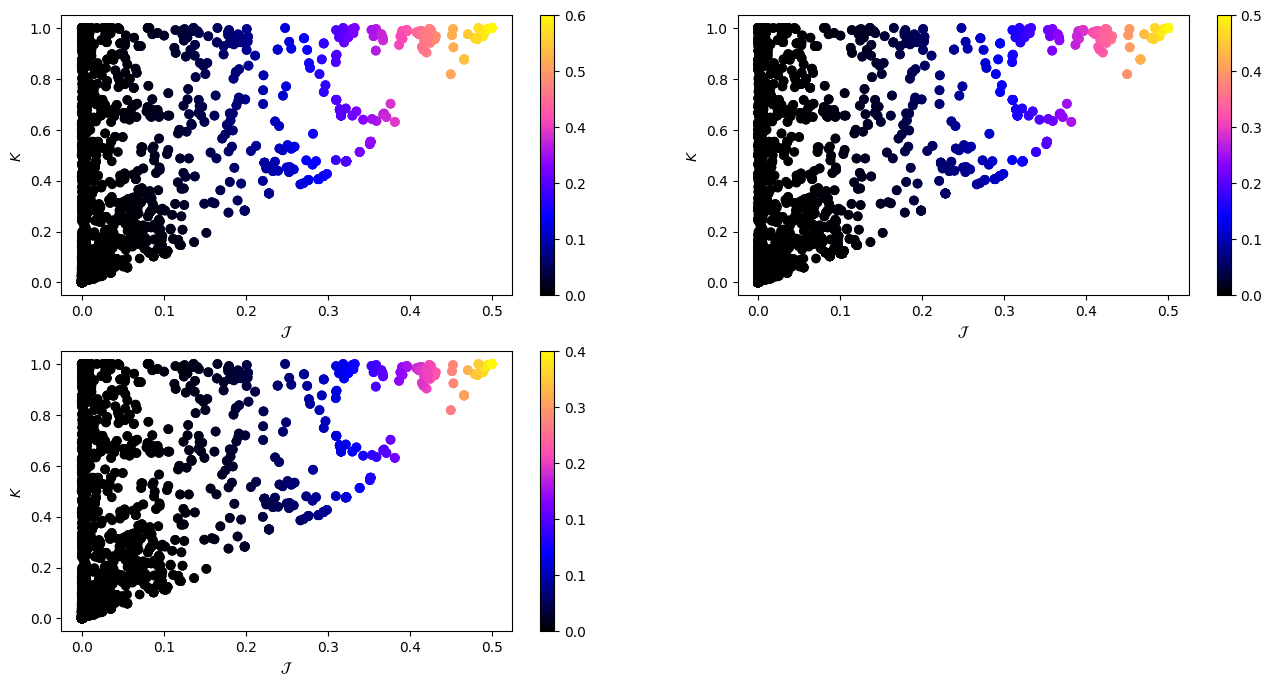

In [30]:
cmap = plt.get_cmap('gnuplot2')
colors = cmap(np.linspace(0, 0.9, 256))
darker_cmap = mcolors.ListedColormap(colors)

custom_ticks = np.linspace(0, 1, 6)
x_custom_ticks = np.linspace(0, 0.5, 6)

def create_scatter_plot(ax, x_data, y_data, color_data, cmap, custom_ticks, x_custom_ticks):
    scatter = ax.scatter(x_data, y_data, c=color_data, cmap=cmap)
    cbar = plt.colorbar(scatter, ax=ax)
    max_val = color_data.max()
    custom_ticks = np.linspace(0, max_val, 6)
    cbar.set_ticks(custom_ticks)
    cbar.set_ticklabels([f'{tick:.1f}' for tick in custom_ticks])
    ax.set_xticks(x_custom_ticks)
    ax.set_xticklabels([f'{tick:.1f}' for tick in x_custom_ticks])
    ax.set_xlabel(r'$\mathcal{J}$')
    ax.set_ylabel("$K$")

fig = plt.figure(figsize=(16, 8))

data = [
    ('relaxed_continous_quality', 'multiset_jaccard', 'cardinality_proportion'),
    ('balanced_continous_quality', 'multiset_jaccard', 'cardinality_proportion'),
    ('strict_continous_quality', 'multiset_jaccard', 'cardinality_proportion')
]

for i, (color_data_key, x_data_key, y_data_key) in enumerate(data, start=1):
    ax = fig.add_subplot(2, 2, i)
    create_scatter_plot(ax, sem_syn_joins[x_data_key], sem_syn_joins[y_data_key], sem_syn_joins[color_data_key], darker_cmap, custom_ticks, x_custom_ticks)

In [ ]:
sem_syn_joins = sem_syn_joins[["ds_name", "att_name", "ds_name_2", "att_name_2", 
                              "containment", "cardinality_proportion", "jaccard", "multiset_jaccard", 
                              "relationship", "balanced_continous_quality"]] # We keep only the balanced quality and the relevant columns (i.e. no rankings)
sem_syn_joins = sem_syn_joins.rename(columns={"balanced_continous_quality": "quality"}) # Rename simply to quality

sem_syn_joins.to_csv(f'{data_folder}/semantic_and_syntactic_joins_with_continuous_quality.csv', index=False)
sem_syn_joins

,ds_name,att_name,ds_name_2,att_name_2,containment,cardinality_proportion,jaccard,multiset_jaccard,relationship,quality
0,Distributions_data_2016.csv,demographics,Tech_sector_diversity_demographics_2016.csv,raceEthnicity,0.230769,0.461538,0.187500,0.000186,syntactic,1.041278e-05
1,USA_cars_datasets.csv,country,world_country.csv,Name,0.500000,0.008368,0.004167,0.000365,semantic,4.659192e-07
2,books_updated.csv,languageCode,countries_metadatacountries.csv,CountryCode,0.360000,0.101215,0.034091,0.000878,syntactic,1.381148e-05
3,cars.csv,color,colors.csv,name,0.750000,0.088889,0.065217,0.000233,semantic,3.200301e-06
4,cars.csv,transmission,imdb_ijs_movies.csv,name,0.500000,0.000044,0.000022,0.000011,syntactic,7.529394e-11
...,...,...,...,...,...,...,...,...,...,...
4313,student-mat.csv,Pstatus,dataset_1_anneal.csv,temper_rolling,0.500000,0.500000,0.333333,0.000773,syntactic,4.488233e-05
4314,top10s.csv,title,song_data.csv,songname,0.493151,0.045159,0.021567,0.014713,semantic,1.131892e-04
4315,top_100_books.csv,author2,books_updated.csv,authors,0.409639,0.017903,0.006999,0.003268,semantic,9.130448e-06
4316,us_companies.csv,companytype,worldcitiespop.csv,Country,0.111111,0.038462,0.000000,0.000000,syntactic,0.000000e+00
